In [23]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

In [24]:
torch.manual_seed(42)
np.random.seed(42)


In [25]:
#creating sample dataset
seq_length=10
num_sequences=1000
sequences = []
targets = []

for _ in range(num_sequences):
    # random sequence
    seq = np.random.randn(seq_length)
    # target is the sum of the sequence
    target = np.sum(seq)
    
    sequences.append(seq)
    targets.append(target)

# converting to tensors
sequences = torch.FloatTensor(sequences)
targets = torch.FloatTensor(targets).reshape(-1, 1)

In [26]:
# train loader
dataset = TensorDataset(sequences, targets)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [27]:
#simple RNN model
rnn = nn.RNN(
        input_size=1,
        hidden_size=32,
        num_layers=1,
        batch_first=True
    )
fc = nn.Linear(32, 1)

In [28]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(list(rnn.parameters()) + list(fc.parameters()), lr=0.01)

In [29]:
# lists to store gradient norms
gradient_norms = []

#training loop
for epoch in range(50):
    total_loss = 0
    
    for batch_idx, (sequences, targets) in enumerate(train_loader):
        # Reshape input for RNN (batch_size, seq_length, input_size)
        sequences = sequences.unsqueeze(-1)
        batch_size = sequences.size(0)
        
        # Initialize hidden state
        h0 = torch.zeros(1, batch_size, rnn.hidden_size)
        
        # Forward pass
        # RNN forward
        out, _ = rnn(sequences, h0)
        # FC layer forward
        out = fc(out[:, -1, :])
        
        # Calculate loss
        loss = criterion(out, targets)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # Calculate gradient norm
        total_norm = 0
        for p in list(rnn.parameters()) + list(fc.parameters()):
            if p.grad is not None:
                param_norm = p.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
        total_norm = total_norm ** 0.5
        
        # Store gradient norm
        if batch_idx == 0:  # Store only first batch of each epoch
            gradient_norms.append(total_norm)
        
        optimizer.step()
        total_loss += loss.item()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{50}], Loss: {total_loss/len(train_loader):.4f}')


Epoch [10/50], Loss: 0.1024
Epoch [20/50], Loss: 0.0691
Epoch [30/50], Loss: 0.2233
Epoch [40/50], Loss: 0.0949
Epoch [50/50], Loss: 0.0514


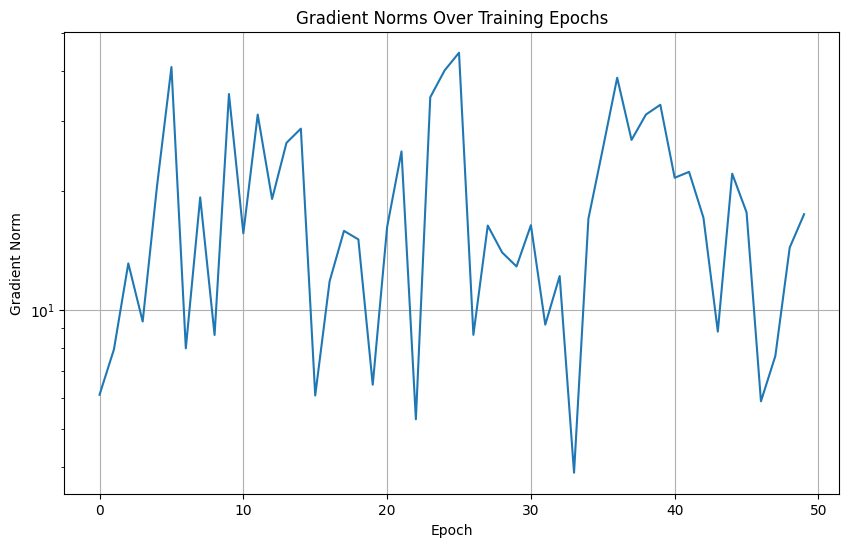

In [30]:

# Plot gradient norms
plt.figure(figsize=(10, 6))
plt.plot(gradient_norms)
plt.title('Gradient Norms Over Training Epochs')
plt.xlabel('Epoch')
plt.ylabel('Gradient Norm')
plt.yscale('log')
plt.grid(True)
plt.show()

In [33]:
import pandas as pd

# Load the dataset
data = pd.read_csv('chat_dataset.csv')

# Display the first few rows of the dataset
print(data.head())


                              message sentiment
0          I really enjoyed the movie  positive
1               The food was terrible  negative
2  I'm not sure how I feel about this   neutral
3           The service was excellent  positive
4              I had a bad experience  negative


In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 584 entries, 0 to 583
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   message    584 non-null    object
 1   sentiment  584 non-null    object
dtypes: object(2)
memory usage: 9.3+ KB


In [60]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kaira\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [78]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping


In [79]:
# Load the dataset
df = pd.read_csv('chat_dataset.csv')

# Check class distribution
print(df['sentiment'].value_counts())

# Encode labels
label_encoder = LabelEncoder()
df['sentiment_encoded'] = label_encoder.fit_transform(df['sentiment'])

sentiment
neutral     259
positive    178
negative    147
Name: count, dtype: int64


In [80]:
# Tokenize text
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(df['message'])
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

In [81]:
# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df['message'])
padded_sequences = pad_sequences(sequences, padding='post')

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, 
    df['sentiment_encoded'], 
    test_size=0.2, 
    random_state=42
)

# Convert labels to categorical
num_classes = len(label_encoder.classes_)
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

In [82]:
embedding_dim = 64
rnn_units = 64

model = Sequential([
    Embedding(vocab_size, embedding_dim, mask_zero=True),
    SimpleRNN(rnn_units, return_sequences=False),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [83]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping]
)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.4108 - loss: 1.0899 - val_accuracy: 0.4530 - val_loss: 1.0585
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5830 - loss: 0.9845 - val_accuracy: 0.4957 - val_loss: 1.0064
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6539 - loss: 0.8822 - val_accuracy: 0.5556 - val_loss: 0.9336
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7052 - loss: 0.7710 - val_accuracy: 0.5897 - val_loss: 0.8337
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7921 - loss: 0.6161 - val_accuracy: 0.6325 - val_loss: 0.7431
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8356 - loss: 0.5138 - val_accuracy: 0.6325 - val_loss: 0.7217
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8862 - loss: 0.4334 - val_accuracy: 0.6581 - val_loss: 0.7034
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8896 - loss: 0.3775 - val_accuracy: 0.6838 - val_loss: 0.6826
Epoch 9

In [84]:
# Evaluate on test set
loss, accuracy = model.evaluate(X_test, y_test_cat)
print(f"Test Accuracy: {accuracy*100:.2f}%")

# Function to predict sentiment
def predict_sentiment(text):
    sequence = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequence, maxlen=X_train.shape[1], padding='post')
    prediction = model.predict(padded)
    predicted_class = np.argmax(prediction, axis=-1)
    return label_encoder.inverse_transform(predicted_class)[0]

# Test some examples
test_samples = [
    "I love this product! It's amazing!",
    "The service was terrible and slow.",
    "I'm not sure how I feel about this."
]

for sample in test_samples:
    print(f"Message: {sample}")
    print(f"Predicted sentiment: {predict_sentiment(sample)}\n")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7331 - loss: 0.6309
Test Accuracy: 75.21%
Message: I love this product! It's amazing!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
Predicted sentiment: positive

Message: The service was terrible and slow.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted sentiment: negative

Message: I'm not sure how I feel about this.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted sentiment: neutral

